In [1]:
## Include packages

using DelimitedFiles
using DCAUtils
using PyPlot
using Statistics
using KitMSA
using FastaIO
using LinearAlgebra
using StatsBase

include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
include("../src/mutability.jl")
;

In [1]:
function write_cde_of_chains(folder, out_path, mask, h, J, n)
    fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder))
    res = []
    for i in 1:n
        chain = Int8.(fasta2matrix(joinpath(folder_path, fasta_files[i])))[mask,:]
        cde_msa = hcat([cont_dep_entr_without_deg(chain[step,:], h, J) 
                for step in 1:length(chain[:,1])]...)'
        push!(res, vec(cde_msa))
        if i %10 == 0
            println(i)
        end
    end
    writedlm(out_path, hcat(res...))
    #return hcat(res...)
end


function read_par_BM_standardorder(path::AbstractString, q::Integer = 21)
    params = readdlm(path,' ', use_mmap = true)[:, 2:6]
    l_file = size(params, 1)
    N = Integer(((q - 2) + sqrt( (q-2)^2 + 8*l_file))/(2*q))
    J = Array{Float64}(undef, q, q, N, N)
    h = Array{Float64}(undef, q, N)
    n_J = Int(q*q*N*(N-1)/2)
    n_h = q*N
    for k in 1:n_J
        i, j, a, b, par_j = params[k, :]
        i += 1
        j += 1
        a += 1
        b += 1
        J[a, b, i, j] = par_j
    end
    for l in (n_J + 1): n_h + n_J
        i, a, par_h = params[l, :]
        i += 1
        a += 1
        h[a, i] = par_h
    end
    return h, J
end

function read_par_BM_save(path::AbstractString, q::Integer = 21)    
    params = readdlm(path,' ', use_mmap = true)[:, 2:6]
    l_file = size(params, 1) 
    N = Integer(((q - 2) + sqrt( (q-2)^2 + 8*l_file))/(2*q))
    J = Array{Float64}(undef, q, q, N, N)
    h = Array{Float64}(undef, q, N)
    n_J = Int(q*q*N*(N-1)/2)
    n_h = q*N

    for k in 1:n_J
        i, j, a, b, par_j = params[k, :]
        i += 1
        j += 1
        a == 0 && (a = 21)
        b == 0 && (b = 21)
        J[a, b, i, j] = par_j
    end

    for l in (n_J + 1): n_h + n_J
        i, a, par_h = params[l, :]
        i += 1
        a == 0 && (a = 21)
        h[a, i] = par_h
    end

    return h, J
end

read_par_BM_save (generic function with 2 methods)

In [3]:
using DelimitedFiles

PATH_PAR = "../../DHFR_pars/Parameters_conv_DHFR.dat"
h_new, J_new = read_par_BM_save(PATH_PAR, 21);

In [5]:
println(sum(abs2, h_new))
println(sum(abs2, J_new))

21109.06876327675
2267.4241388247688


In [11]:
size(J_new)

(21, 21, 160, 160)

In [10]:
sum(abs2, J_new .- permutedims(J_new, [2,1,3,4]))

4073.1049090129636

In [3]:
path_nat = "../../DHFR_pars/PF00186_nogapped.fasta"
#path_nat = "../../Serine_Prot/yaakov_short.faa"
nat_MSA = Int8.(fasta2matrix(path_nat))
;

In [4]:
PATH_PAR = "../../DHFR_pars/Parameters_conv_DHFR.dat"
#PATH_PAR = "../../Serine_Prot/2024.5.7.12.23-yaakov_short-bmDCA_params_0.980.dat"
htmp, Jtmp = read_par_BM_standardorder(PATH_PAR)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
println(extrema(J))
println(extrema(h))
;

(-1.212281, 1.744293)
(-12.176782, 0.0)


In [5]:
folder_path = "../../scra_data_beta/sparse_amino_mixed_hdfr1_steps400000_seqs500_T1.0p0.5"
#folder_path = "../../scra_data_beta/amino_mixed_serine_steps450000_seqs100_T1.0p0.5"
fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files]
step_matrices = build_seq_matrices(matrices)
;

 10.322120 seconds (182.73 k allocations: 31.134 MiB, 0.47% compilation time)


## Data for 2B-C-D

In [229]:
start = time()
cde_NAT = []
for i in 1:length(nat_MSA[:,1])
    seq = deepcopy(nat_MSA[i,:])
    push!(cde_NAT, cont_dep_entr_without_deg(seq, h, J))
end
cde_NAT = hcat(cde_NAT...)'
fine = time()
println(fine-start)
#writedlm("../data/figures/data_fig2/cde_NAT", cde_NAT)

145.07905316352844


In [29]:
start_wt = Int.(fasta2matrix("../../DHFR_pars/wt_hinds.fasta")[1,:]);
cde_wt = cont_dep_entr_without_deg(start_wt, h_new, J_new);
#writedlm("../data/figures/data_fig2/cde_PSE", cde_pse)

In [30]:
sum(step_matrices[1][1,:] .== nat_MSA[1,:])

160

In [8]:
L = length(step_matrices[1][1,:])
freqs_nat = reshape(compute_weighted_frequencies(Int8.(nat_MSA'), 22, 0.2)[1], (21, L))
entr_nat = get_entropy(freqs_nat);

θ = 0.2 threshold = 32.0
M = 36612 N = 160 Meff = 8785.59817623452


In [9]:
freqs = [reshape(compute_weighted_frequencies(Int8.(MSA'),22,0.)[1],(21, L)) 
        for MSA in step_matrices]
entr = [get_entropy(f) for f in freqs];
entr = hcat(entr...)';
#writedlm("../data/figures/data_fig2/evol_entr_betalac", entr)

θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500 N = 160 Meff = 500
θ = 0.0 threshold = 0.0
M = 500

In [24]:
cie = entr_nat
epis= [x in sortperm(cie .- cde_wt, rev=true)[1:5] for x in 1:length(cie)]
d_from_neg_bisec = (cde_wt .+ cie .- 2) ./ sqrt(2)
varr = [x in sortperm(d_from_neg_bisec, rev=true)[1:5] for x in 1:length(cie)]
cons = [x in sortperm(d_from_neg_bisec, rev=false)[1:5] for x in 1:length(cie)]
X = [round(Int, n^(3.8)) for n in 1:size(entr,1)];

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


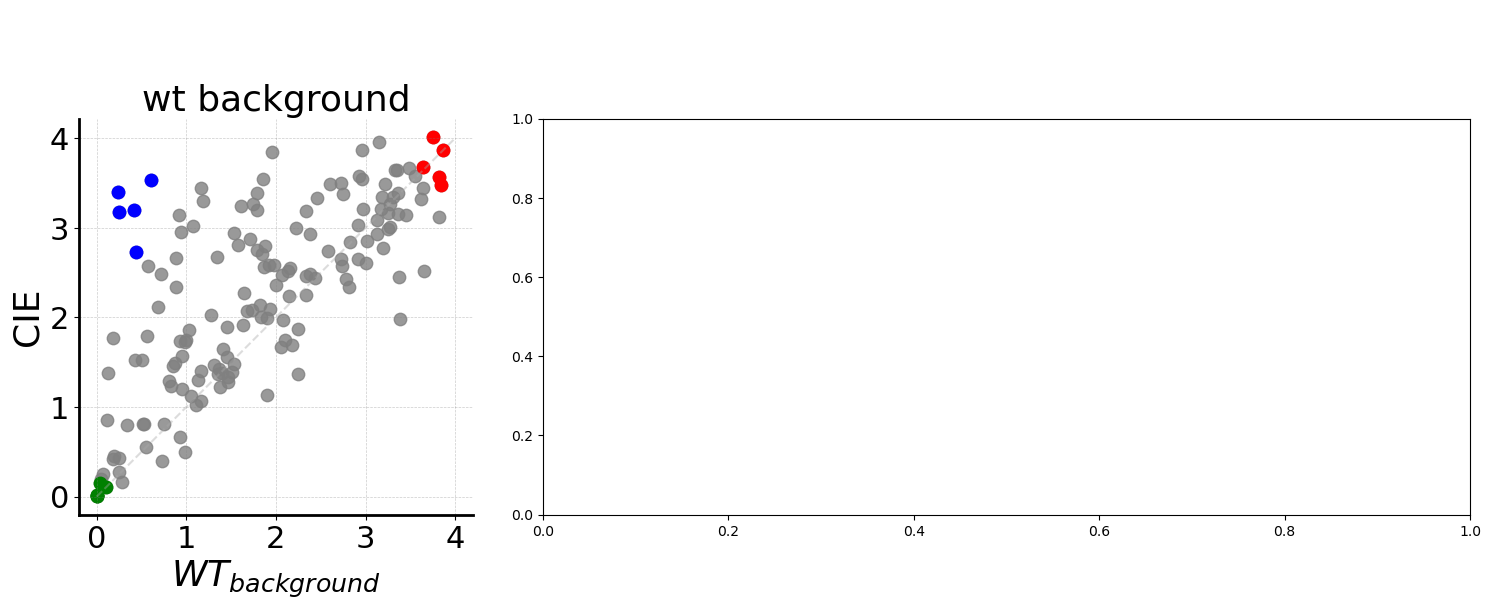

PyObject <matplotlib.legend.Legend object at 0x7fd63018fd30>

In [25]:

pointsize = 80
transp = 0.8
transp2 = 1
lab = [0,1,2,3,4]
lab2 = [10^i for i in 2:7]
axis_width = 2.

ticks_font = 22
axis_font = 26

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)
 
ax1 = plt.subplot2grid(shape=(1, 4), loc=(0, 0), colspan = 1)
ax2 = plt.subplot2grid(shape=(1, 4), loc=(0, 1), colspan = 2)

fig.subplots_adjust(wspace=0.2)

ax1.plot([0, 4.0], [0, 4.0], linestyle="--", alpha = 0.4, color = "darkgrey")
ax1.scatter(cde_wt, cie, color = "grey", s = pointsize, alpha = transp)
ax1.scatter(cde_wt[varr], cie[varr], color = "red", s = pointsize, alpha = transp2)
ax1.scatter(cde_wt[epis], cie[epis], color = "blue",  s = pointsize, alpha = transp2)
ax1.scatter(cde_wt[cons], cie[cons], color = "green",  s = pointsize, alpha = transp2)
ax1.set_xlabel("\$WT_{background}\$", fontsize=axis_font)
ax1.set_ylabel("CIE", fontsize=axis_font)
ax1.grid(color = "grey", linestyle = "--", linewidth = 0.5, alpha = 0.4)
ax1.set_xticks([0,1,2,3,4])
ax1.set_yticks([0,1,2,3,4])
ax1.set_xticklabels(lab, fontsize = ticks_font)
ax1.set_yticklabels(lab, fontsize = ticks_font)
ax1.spines["top"].set_visible(false)
ax1.spines["right"].set_visible(false)
ax1.spines["left"].set_linewidth(axis_width)
ax1.spines["bottom"].set_linewidth(axis_width)
ax1.set_aspect("equal")
ax1.set_title("wt background", fontsize = axis_font)
#=
ax2.plot(X, entr, color = "grey", alpha = 0.35)
ax2.plot(X, entr[:, varr], color = "red", alpha = 0.35)
ax2.plot(X, entr[:, epis], color = "blue", alpha = 0.35)
ax2.plot(X, entr[:, cons], color = "green", alpha = 0.35)
ax2.plot(X, mean(entr[:, varr], dims = 2)[:], color = "red", linewidth=4.5, label = "Variable" )
ax2.plot(X, mean(entr[:, epis], dims = 2)[:], color = "blue", linewidth = 4.5, label = "Epistatic")
ax2.plot(X, mean(entr[:, cons], dims = 2)[:], color = "green", linewidth = 4.5, label = "Conserved")
ax2.plot(X, mean(entr[:, varr], dims = 2)[:], color = "darkred", linewidth=4.5 )
ax2.plot(X, mean(entr[:, epis], dims = 2)[:], color = "midnightblue", linewidth = 4.5)
ax2.plot(X, mean(entr[:, cons], dims = 2)[:], color = "darkgreen", linewidth = 4.5)
ax2.set_xlabel("Monte Carlo steps", fontsize=axis_font)
ax2.set_ylabel("Site Entropy", fontsize=axis_font)
ax2.grid(color = "grey", linestyle = "--", linewidth = 0.5, alpha = 0.4)
ax2.set_yticks([0,1,2,3,4])
ax2.set_xticks(lab2)
ax2.set_xticklabels(lab2, fontsize = ticks_font)
ax2.set_yticklabels(lab, fontsize = ticks_font)
ax2.set_xlim(minimum(X),maximum(X))
ax2.spines["top"].set_visible(false)
ax2.spines["right"].set_visible(false)
ax2.spines["left"].set_linewidth(axis_width)
ax2.spines["bottom"].set_linewidth(axis_width)
ax2.set_xscale("log")
=#
tight_layout()
fig.legend(loc="upper right", fontsize = axis_font, frameon = false, ncol = 3, bbox_to_anchor=(0.6, 1.2))
#savefig("../Serin_Prot_dynamics.png")
#savefig("../dhfr_dynamics.png")

θ = 22.0 threshold = 5588.0
M = 6740 N = 254 Meff = 1.0000000000000608


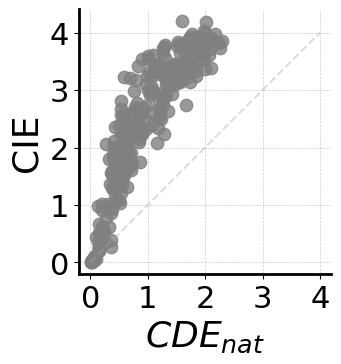

In [261]:
pointsize = 80
transp = 0.8
transp2 = 1
lab = [0,1,2,3,4]
lab2 = [10^i for i in 2:7]
axis_width = 2.

ticks_font = 22
axis_font = 26

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
 
ax1 = plt.subplot2grid(shape=(1, 4), loc=(0, 0), colspan = 1)

fig.subplots_adjust(wspace=0.2)
W = compute_weights(Int8.(nat_MSA'), 22)[1]
ax1.plot([0, 4.0], [0, 4.0], linestyle="--", alpha = 0.4, color = "darkgrey")
ax1.scatter(mean(cde_NAT, weights(W), dims = 1)[:], cie, color = "grey", s = pointsize, alpha = transp)
ax1.set_xlabel("\$CDE_{nat}\$", fontsize=axis_font)
ax1.set_ylabel("CIE", fontsize=axis_font)
ax1.grid(color = "grey", linestyle = "--", linewidth = 0.5, alpha = 0.4)
ax1.set_xticks([0,1,2,3,4])
ax1.set_yticks([0,1,2,3,4])
ax1.set_xticklabels(lab, fontsize = ticks_font)
ax1.set_yticklabels(lab, fontsize = ticks_font)
ax1.spines["top"].set_visible(false)
ax1.spines["right"].set_visible(false)
ax1.spines["left"].set_linewidth(axis_width)
ax1.spines["bottom"].set_linewidth(axis_width)
ax1.set_aspect("equal")
#ax1.set_title("wt background", fontsize = axis_font)
savefig("../cde_cie_Serin_Prot_dynamics.png")

In [26]:
println("CIE")
println(round.(entr_nat, digits = 3))

CIE
[1.119, 1.973, 3.012, 2.463, 1.229, 2.009, 0.426, 3.214, 2.249, 3.264, 1.725, 2.65, 2.363, 0.453, 0.109, 3.156, 2.567, 1.422, 3.344, 1.295, 1.281, 0.807, 2.334, 1.338, 1.388, 2.987, 0.4, 1.646, 2.238, 2.483, 0.28, 1.367, 3.089, 3.027, 0.163, 3.161, 1.364, 2.516, 2.608, 1.748, 1.472, 0.664, 0.014, 0.549, 1.573, 0.499, 2.096, 1.871, 0.811, 1.913, 1.795, 2.079, 1.522, 0.256, 1.135, 2.07, 0.201, 3.377, 1.38, 1.474, 0.808, 1.75, 1.018, 1.696, 2.772, 3.677, 3.481, 3.124, 3.871, 3.445, 2.854, 1.739, 2.477, 3.489, 2.546, 2.577, 3.345, 1.668, 2.438, 2.742, 2.654, 1.454, 2.277, 3.316, 3.579, 2.932, 3.64, 3.665, 4.016, 3.187, 3.26, 2.513, 2.581, 2.484, 1.375, 1.528, 0.01, 0.011, 2.142, 2.87, 1.563, 0.86, 3.002, 2.749, 2.676, 1.892, 2.432, 3.561, 1.987, 2.454, 2.703, 1.993, 2.335, 2.029, 0.151, 3.199, 1.298, 2.844, 3.503, 3.387, 2.792, 2.811, 1.407, 0.415, 1.861, 2.667, 1.222, 0.795, 3.327, 2.725, 2.58, 3.952, 3.645, 3.547, 1.069, 3.483, 2.942, 3.017, 3.542, 3.247, 3.144, 3.843, 3.581, 3.866, 

In [31]:
println("CDE seq 1")
println(round.(cde_wt, digits = 3))

CDE seq 1
[1.056, 2.078, 3.277, 2.338, 0.824, 1.828, 0.25, 2.969, 2.334, 3.27, 0.98, 2.723, 1.997, 0.194, 0.103, 3.358, 1.861, 1.368, 3.18, 0.802, 1.465, 0.516, 2.815, 1.465, 1.509, 3.246, 0.734, 1.413, 2.142, 2.383, 0.243, 2.241, 3.133, 2.911, 0.278, 3.245, 1.356, 2.133, 3.006, 2.101, 1.313, 0.925, 0.005, 0.553, 0.951, 0.982, 1.933, 2.248, 0.754, 1.635, 0.564, 1.729, 0.502, 0.073, 1.901, 1.676, 0.048, 2.748, 0.121, 1.534, 0.529, 0.991, 1.108, 2.182, 3.198, 3.636, 3.843, 3.815, 3.866, 3.639, 3.018, 0.929, 2.063, 3.222, 2.157, 2.742, 3.303, 2.061, 2.434, 2.585, 2.92, 0.852, 1.638, 3.617, 2.931, 3.133, 3.352, 3.479, 3.749, 2.337, 1.74, 3.652, 1.926, 0.712, 1.402, 0.428, 0.004, 0.003, 1.82, 1.711, 1.458, 0.116, 2.22, 1.789, 1.339, 1.45, 2.782, 3.814, 3.386, 3.372, 1.839, 1.901, 0.889, 1.275, 0.036, 1.791, 1.128, 2.825, 2.725, 3.358, 1.882, 1.582, 1.16, 0.182, 1.032, 0.88, 1.373, 0.335, 2.455, 0.441, 1.975, 3.154, 3.331, 2.955, 1.164, 2.599, 1.532, 1.071, 1.86, 1.609, 3.452, 1.956, 3.55, 2

In [34]:
println(start_wt)

[21, 10, 12, 2, 8, 18, 1, 18, 16, 14, 12, 11, 6, 8, 6, 9, 12, 6, 3, 10, 13, 19, 13, 10, 15, 12, 4, 5, 9, 20, 5, 14, 15, 11, 17, 17, 14, 12, 10, 18, 8, 11, 6, 15, 9, 17, 19, 5, 16, 8, 13, 15, 13, 10, 9, 3, 15, 8, 12, 8, 18, 10, 16, 15, 4, 10, 9, 4, 13, 13, 15, 6, 1, 7, 5, 1, 9, 16, 10, 3, 3, 1, 10, 15, 10, 8, 4, 14, 9, 18, 3, 11, 18, 19, 8, 18, 6, 6, 16, 16, 18, 20, 14, 4, 1, 11, 12, 14, 13, 6, 15, 10, 5, 18, 17, 15, 8, 11, 14, 4, 5, 4, 16, 3, 17, 5, 5, 13, 4, 8, 3, 10, 6, 9, 20, 9, 10, 10, 13, 4, 20, 13, 16, 4, 18, 14, 4, 4, 9, 6, 8, 9, 20, 9, 5, 4, 18, 20, 4, 9]


In [38]:
size(J)

(21, 21, 160, 160)

In [42]:
J_new[:,:,1,10]

21×21 Matrix{Float64}:
 -1.4e-5     1.2e-5    -1.8e-5    …   1.3e-5     1.3e-5     1.3e-5
 -1.1e-5     1.2e-5    -1.4e-5        1.3e-5     1.2e-5     1.3e-5
 -4.0e-6     1.3e-5    -2.4e-5        1.3e-5     1.2e-5     1.3e-5
 -1.4e-5     1.2e-5    -1.2e-5        1.3e-5     1.2e-5     1.3e-5
 -1.1e-5     1.2e-5    -2.1e-5        1.3e-5     1.3e-5     1.2e-5
 -6.0e-6     1.3e-5    -1.1e-5    …   1.2e-5     1.2e-5     1.3e-5
 -1.1e-5     1.3e-5    -2.0e-5        1.3e-5     1.3e-5     1.3e-5
 -6.0e-6     1.3e-5    -2.0e-5        1.2e-5     1.3e-5     1.3e-5
 -0.004365  -0.003002  -0.009181     -0.001002  -0.002076  -0.001246
 -1.2e-5     1.2e-5    -1.4e-5        1.3e-5     1.2e-5     1.3e-5
 -0.072452  -0.009164   0.046482  …  -0.003117   0.006037   0.004627
 -1.1e-5     1.3e-5    -1.9e-5        1.3e-5     1.2e-5     1.3e-5
 -2.1e-5     1.2e-5    -2.0e-5        1.3e-5     1.3e-5     1.2e-5
 -1.8e-5     1.2e-5    -1.8e-5        1.3e-5     1.3e-5     1.3e-5
 -1.2e-5     1.3e-5    -1.8e-5     

In [52]:
sum(abs2, J_new)#energy(h_new, J_new, nat_MSA)

2267.4241388247688

In [53]:
sum(abs2, h)

115699.38725802439

In [48]:
function compute_energy_single_sequence(h::Array{Float64,2},
                                        J::Array{Float64,4},
                                        S::Vector)
    N = size(h)[2]
    q = size(h)[1]
    E = 0.0
    for i = 1:N
        E -= h[S[i],i]
        for j = (i+1):N
            E -= J[S[i],S[j],i,j]
        end
    end
return E
end

compute_energy_single_sequence (generic function with 1 method)

In [49]:
compute_energy_single_sequence(h_new, J_new, start_wt)

-811.5862109999962

In [54]:
extrema(J_new)

(-1.212281, 1.744293)